In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def  load_and_process_data(filepath):
    df = pd.read_csv(filepath)

    df['anime'] = df['anime'].astype(str).str.strip()
    df['anime'] = df['anime'].map({'Да': 1, 'Нет': 0})

    df = df.dropna(subset=['anime'])

    feature_cols = ['sex', 'age', 'score', 'social', 'os', 'ai']

    X_raw = df[feature_cols].copy()
    y = df['anime'].values

    X_raw['sex'] = X_raw['sex'].map({'M': 0, 'Ж': 1}).fillna(0)

    X_raw['age'] = pd.to_numeric(X_raw['age'], errors='coerce')
    X_raw['age'] = X_raw['age'].fillna(X_raw['age'].mean())

    X_raw['score'] = pd.to_numeric(X_raw['score'], errors='coerce')
    X_raw['score'] = X_raw['score'].fillna(X_raw['score'].mean())

    for col in ['social', 'os', 'ai']:
        X_raw[col] = X_raw[col].astype(str).str.strip()
        unique_vals = X_raw[col].unique()
        mapping = {val: i for i, val in enumerate(unique_vals)}
        X_raw[col] = X_raw[col].map(mapping)

    X = X_raw.values
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0) + 1e-9
    X_scaled = (X - mean) / std

    return X_scaled, y

In [3]:
data, target = load_and_process_data('../datasets/famcs_students.csv')

In [4]:
np.random.seed(42)
indices = np.random.permutation(len(target))

In [5]:
n_total = len(target)
n_train = int(0.70 * n_total)
n_val = int(0.15 * n_total)

In [6]:
train_idx = indices[:n_train]
val_idx = indices[n_train : n_train + n_val]
test_idx = indices[n_train + n_val:]

In [7]:
X_train, y_train = data[train_idx], target[train_idx]
X_val, y_val = data[val_idx], target[val_idx]
X_test, y_test = data[test_idx], target[test_idx]

In [8]:
X_train.shape

(88, 6)

In [9]:
X_val.shape

(19, 6)

In [10]:
X_test.shape

(20, 6)

In [11]:
def calculate_metrics(y_true, y_pred, y_prob=None):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / len(y_true)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    from sklearn.metrics import roc_auc_score
    try:
        roc = roc_auc_score(y_true, y_prob) if y_prob is not None else 0.5
    except:
        roc = 0.5

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc,
        'confusion_matrix': np.array([[tn, fp], [fn, tp]])
    }

In [12]:
class DummyClassifier:
    def fit(self, X, y):
        self.mode = np.bincount(y.astype(int)).argmax()

    def predict(self, X):
        return np.full(X.shape[0], self.mode)
    
    def predict_proba(self, X):
        probs = np.zeros(X.shape[0])
        if self.mode == 1:
            probs += 1
        return probs

In [13]:
class CustomNaiveBayes:
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        self._mean = np.zeros((n_classes, n_features))
        self._var = np.zeros((n_classes, n_features))
        self._priors = np.zeros(n_classes)

        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0) + 1e-9
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def _gaussian_pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
    
    def predict_proba(self, X):
        probs_list = []
        for x in X:
            posteriors = []
            for idx, c in enumerate(self.classes):
                prior = np.log(self._priors[idx])
                class_conditional = np.sum(np.log(self._gaussian_pdf(idx, x)))
                posteriors.append(prior + class_conditional)

            posteriors = np.array(posteriors)
            posteriors = np.exp(posteriors - np.max(posteriors))
            posteriors = posteriors / posteriors.sum()

            idx_1 = np.where(self.classes == 1)[0]
            if len(idx_1) > 0:
                probs_list.append(posteriors[idx_1[0]])
            else:
                probs_list.append(0.0)
        return np.array(probs_list)
    

    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs > 0.5).astype(int)

In [14]:
class CustomKNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = []
        for row in X:
            distances = np.sqrt(np.sum((self.X_train - row)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            vote = np.bincount(k_nearest_labels.astype(int)).argmax()
            y_pred.append(vote)
        return np.array(y_pred)
    
    def predict_proba(self, X):
        y_prob = []
        for row in X:
            distances = np.sqrt(np.sum((self.X_train - row)**2, axis=1))
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            prob = np.mean(k_nearest_labels)
            y_prob.append(prob)
        return np.array(y_prob)

In [15]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.threshold = 0.5

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return (probs > self.threshold).astype(int)


In [16]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

In [17]:
nb = CustomNaiveBayes()
nb.fit(X_train, y_train)

In [18]:
best_k = 1
best_acc = 0
k_values = list(range(1, 21))
acc_scores = []

In [19]:
for k in k_values:
    knn_temp = CustomKNN(k=k)
    knn_temp.fit(X_train, y_train)
    preds = knn_temp.predict(X_val)
    acc = np.mean(preds == y_val)
    acc_scores.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_k = k

In [20]:
best_k

2

In [21]:
best_acc

np.float64(0.631578947368421)

In [22]:
knn = CustomKNN(k=best_k)
knn.fit(X_train, y_train)

In [23]:
log_reg = CustomLogisticRegression(learning_rate=0.1, n_iters=3000)
log_reg.fit(X_train, y_train)

In [24]:
val_probs = log_reg.predict_proba(X_val)
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []
precisions = []
recalls = []

In [25]:
best_f1 = 0
best_thresh = 0.5

In [26]:
for t in thresholds:
    preds_t = (val_probs > t).astype(int)
    m = calculate_metrics(y_val, preds_t)
    f1_scores.append(m['f1'])
    precisions.append(m['precision'])
    recalls.append(m['recall'])

    if m['f1'] > best_f1:
        best_f1 = m['f1']
        best_thresh = t

In [27]:
best_thresh

np.float64(0.1489795918367347)

In [28]:
best_f1

np.float64(0.6153846153846153)

In [29]:
log_reg.threshold = best_thresh

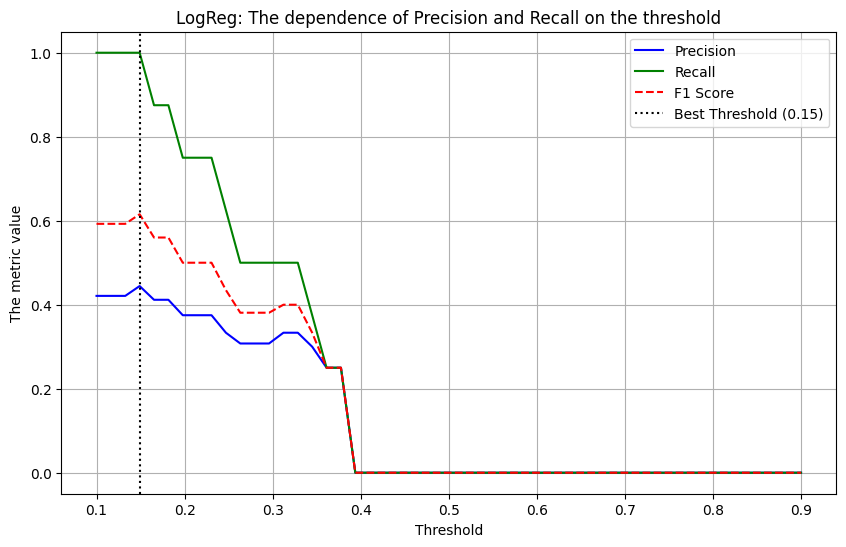

In [30]:
plt.figure(figsize=(10, 6))
plt.title('LogReg: The dependence of Precision and Recall on the threshold')
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1 Score', color='red', linestyle='--')
plt.axvline(best_thresh, color='black', linestyle=':', label=f'Best Threshold ({best_thresh:.2f})')
plt.xlabel('Threshold')
plt.ylabel('The metric value')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
models = {
    'Trivial (Mode)': dummy,
    'Naive Bayes': nb,
    f'k-NN (k={best_k})': knn,
    f'LogReg (Tr={best_thresh:.2f})': log_reg
}

In [32]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    metrics = calculate_metrics(y_test, y_pred, y_prob)

    print(name)
    print(metrics['accuracy'])
    print(metrics['precision'])
    print(metrics['recall'])
    print(metrics['roc_auc'])
    cm = metrics['confusion_matrix']
    print(cm[0,0], cm[0,1])
    print(cm[1,0], cm[1,1])

Trivial (Mode)
0.6
0
0.0
0.5
12 0
8 0
Naive Bayes
0.55
0.0
0.0
0.4479166666666667
11 1
8 0
k-NN (k=2)
0.55
0.42857142857142855
0.375
0.5
8 4
5 3
LogReg (Tr=0.15)
0.45
0.42105263157894735
1.0
0.4791666666666667
1 11
0 8
